In [1]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
from datetime import datetime
from scipy.fft import fft, fftfreq
#mpl.rcParams['figure.figsize'] = (10, 5)
mpl.rcParams['axes.grid'] = False

In [2]:
# 目前 TF 是否使用 GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Functions

In [3]:
def safely_mkdir(dirPath:str):
    '''安全地生成目錄，若目錄已存在則無動作'''
    if os.path.exists(dirPath):
        print("Directory is exist.")
    os.makedirs(dirPath, exist_ok=True) 
    return dirPath

In [4]:
def printlog(msg:str, dirPath:str, mode='a', sep=' ', end='\n', flush=False):
    '''print to std.out and 
    write to log file at the same time'''
    print(msg, sep=sep, end=end, flush=flush)
    with open(dirPath, mode=mode) as f:
        print(msg, file=f, sep=sep, end=end, flush=flush)

In [5]:
def MyFFT(fftInput, hamming, T):
    '''快速傅立葉變換'''
    if hamming:
        fftInput = fftInput * np.hamming(len(fftInput)) # hamming窗函數，減少頻率洩漏

    N = len(fftInput) # Number of sample points
    # T = 1.0 / 9.0 # sample spacing # 應使用傳入值T
    ## x = np.linspace(0.0, N*T, N, endpoint=False)
    y = fftInput
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]

    yf_regular = 2.0/N * np.abs(yf[0:N//2])


    return xf, yf_regular #*1.85 #漢明窗振幅補償

In [6]:
def visualize_candlestick_ver1(df, show_day:np.array):
    '''show raw data candlestick
    顏色採台灣股市風格：紅色表示漲, 綠色表示跌
    資料視覺化: Ref.: https://towardsdatascience.com/basics-of-ohlc-charts-with-pythons-matplotlib-56d0e745a5be
    Paremeter:
    * df: DataFrame (須包含 open, close, high, low)
    * show_day: array, [開始日:int, 結束日:int]
    '''
    x = np.arange(0,len(df[show_day[0]:show_day[1]]))
    fig, ax = plt.subplots(1, figsize=(12,4))

    for idx, val in df[show_day[0]:show_day[1]].iterrows():   
        color = ('red' if val['open'] > val['close'] else 'green')
        # high/low lines
        plt.plot([x[idx], x[idx]], 
                [val['low'], val['high']], 
                color='black')
        # open marker
        plt.plot([x[idx], x[idx]-0.1], 
                [val['open'], val['open']], 
                color=color)
        # close marker
        plt.plot([x[idx], x[idx]+0.1], 
                [val['close'], val['close']], 
                color=color)

    # ticks: date
    #plt.xticks(x[::3], df_apple.date.dt.date[::3])
    ax.set_xticks(x, minor=True) # apply to every ticks

    # labels
    plt.ylabel('USD')

    # grid
    ax.xaxis.grid(color='black', linestyle='dashed', which='both', alpha=0.1)

    # remove spines
    #ax.spines['right'].set_visible(False)
    #ax.spines['top'].set_visible(False)

    # title
    plt.title('IBM Stock Price', loc='left', fontsize=20)
    safely_mkdir('./img')
    plt.savefig(f'./img/candlestick.png')
    plt.show()

In [7]:
#import mplfinance as mpf
def visualize_candlestick_ver2(df=None, type='candle', mav=[5], show_day=None):
    '''Use mpf package to show candlestick
    K 線圖 (Candlestick Chart)
    均線: moving averages with the mav keyword, [5日均線]
    ---
    Paremter:
    * df: DataFrame (須包含 open, close, high, low)
    * type: 顯示模式
    * mav: 均線
    * show_day: array, [開始日:int, 結束日:int]
    '''
    #df = df.copy()
    #df.index = pd.to_datetime(df.index, unit="D")
    #mpf.plot(df[show_day[0]:show_day[1]], type=type, mav=mav, datetime_format='%b %d')
    #print("因資料集無法獲得確切時間，因此 x 軸並非真實日期")

## 實驗日期與紀錄檔

In [8]:
# Get current date and time
datetime_thisRun = datetime.now() 

In [9]:
# Loggering dirName
log_dirName = f'log/{datetime_thisRun.strftime("%Y_%m_%d__%H_%M_%S")}'
# Make dir of Loggering
safely_mkdir(log_dirName)
# log datetime
printlog(f"Date: {datetime_thisRun}", f'{log_dirName}/log.txt')

Date: 2022-04-21 22:53:36.021919


## 亂數種子設定

In [10]:
# 使用 random BitGenerator 隨機生出一個介於 0 ~ 2**32-1 的整數
rng = np.random.default_rng()
myseed = rng.integers(0b11111111111111111111111111111111, size=1) # numpy seed 為 unsign int32 
printlog(f"Random seed: {myseed}", f'{log_dirName}/log.txt')

np.random.seed(seed = myseed) # follow MT19937 by default, seed range is 0 ~ 2**32 - 1
tf.random.set_seed(myseed)

Random seed: [640133537]


## Import Data and Preprocessing
* 可以假設助教測試時的 Training 與 Testing data 時間會接續，因此不必自己處理爬蟲及資料時間有斷開的問題

In [46]:
# import raw training data (test data 留到 model train 好之後再匯入)
training_data = "training_data.csv" #load_data(args.training)
raw_train_df = pd.read_csv(training_data, header=None)

In [47]:
# 欄位重新命名
raw_train_df.rename(columns={0:'open', 1:'high', 2:'low', 3:'close'}, inplace=True)
print(f"Data counts: {len(raw_train_df)}\n", raw_train_df, '\n') 

Data counts: 1488
         open    high     low   close
0     186.73  188.71  186.00  186.30
1     185.57  186.33  184.94  185.54
2     184.81  185.03  183.10  184.66
3     184.39  184.48  182.31  182.54
4     182.20  182.27  180.27  181.59
...      ...     ...     ...     ...
1483  151.95  152.20  151.33  151.84
1484  152.06  152.49  151.62  151.98
1485  152.35  152.93  151.70  152.47
1486  152.81  153.61  152.17  153.55
1487  153.65  154.41  153.08  153.97

[1488 rows x 4 columns] 



Directory is exist.


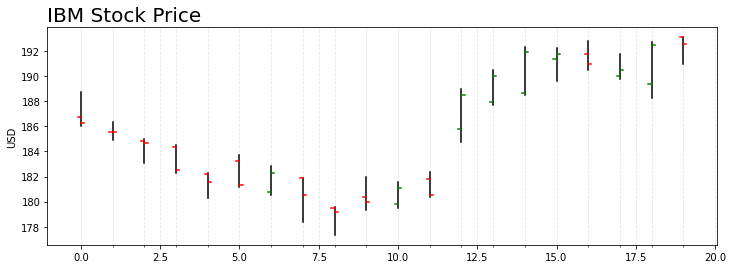

In [48]:
# 視覺化： show raw data candlestick (自製：顯示前二十天的)
visualize_candlestick_ver1(raw_train_df, show_day=[0,20])

In [49]:
# 視覺化： K 線圖 (Candlestick Chart)
# Use mpf package to show candlestick
# 均線: moving averages with the mav keyword, [5日均線, 10日均線, 20日均線, 60日均線, 120日均線]
#visualize_candlestick_ver2(raw_train_df, type='candle', mav=[5,10,20,60,120], show_day=[0,200])

Directory is exist.


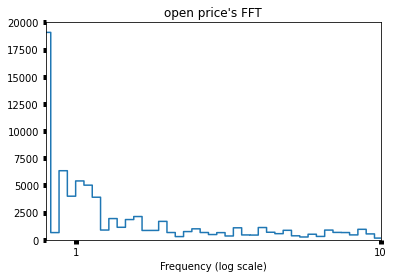

In [50]:
# 視覺化：將時域轉成頻域
fft = tf.signal.rfft(raw_train_df['open'])
f_per_dataset = np.arange(0, len(fft))

n_samples_d = len(raw_train_df['open'])
days_per_year = 365.2425
years_per_dataset = n_samples_d/(days_per_year)
f_per_year = f_per_dataset/years_per_dataset

plt.title("open price's FFT")
plt.step(f_per_year, np.abs(fft))
#plt.xscale('log')
plt.ylim(0, 20000)
plt.xlim([0.1, 10])
plt.tick_params(width=5)
plt.xticks([1, 10]) # labels=['a','b']
_ = plt.xlabel('Frequency (log scale)')
safely_mkdir('./img')
plt.savefig(f'./img/fft.png')

### MOVING AVERAGE 
https://www.geeksforgeeks.org/how-to-calculate-moving-average-in-a-pandas-dataframe/

In [51]:
# Add MOVING AVERAGE Columns (計算日均值)
raw_train_df['open-MA 5 days'] = raw_train_df['open'].rolling(5).mean()
raw_train_df['open-MA 10 days'] = raw_train_df['open'].rolling(10).mean()
raw_train_df['open-MA 20 days'] = raw_train_df['open'].rolling(20).mean()
raw_train_df['open-MA 60 days'] = raw_train_df['open'].rolling(60).mean()
raw_train_df['open-MA 120 days'] = raw_train_df['open'].rolling(120).mean()

raw_train_df['close-MA 5 days'] = raw_train_df['close'].rolling(5).mean()
raw_train_df['close-MA 10 days'] = raw_train_df['close'].rolling(10).mean()
raw_train_df['close-MA 20 days'] = raw_train_df['close'].rolling(20).mean()
raw_train_df['close-MA 60 days'] = raw_train_df['close'].rolling(60).mean()
raw_train_df['close-MA 120 days'] = raw_train_df['close'].rolling(120).mean()
  
# 移除最前面計算平均時, 因天數不足導致 MA 欄位為 NaN 的資料 
# Removing all the NULL values using dropna() method
raw_train_df.dropna(inplace=True)
  
# printing Dataframe
raw_train_df

,open,high,low,close,open-MA 5 days,open-MA 10 days,open-MA 20 days,open-MA 60 days,open-MA 120 days,close-MA 5 days,close-MA 10 days,close-MA 20 days,close-MA 60 days,close-MA 120 days
119,193.87,194.88,193.22,193.70,197.608,196.022,194.2800,199.944667,196.971583,196.618,195.745,194.3015,199.962833,197.122750
120,192.48,193.39,191.68,192.86,196.590,195.610,194.1485,199.717833,197.019500,195.532,195.780,194.2295,199.706000,197.177417
121,193.54,193.68,190.75,191.95,195.532,195.750,194.0645,199.464500,197.085917,194.136,195.520,194.0040,199.427667,197.230833
122,192.14,193.70,190.90,193.00,194.220,195.528,193.9315,199.184167,197.147000,192.980,195.510,193.9275,199.153167,197.300333
123,191.23,192.08,188.90,191.40,192.652,195.351,193.7880,198.882833,197.204000,192.582,195.140,193.8525,198.851500,197.374167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,151.95,152.20,151.33,151.84,151.046,149.844,151.3720,149.022167,148.928417,151.008,149.771,151.1415,148.879000,148.799417
1484,152.06,152.49,151.62,151.98,151.590,149.985,151.2480,149.172833,148.928917,151.610,150.053,151.0565,149.028167,148.796167
1485,152.35,152.93,151.70,152.47,151.932,150.332,151.1775,149.329000,148.923083,152.002,150.460,150.9620,149.168000,148.808583
1486,152.81,153.61,152.17,153.55,152.234,150.818,151.1015,149.484167,148.938167,152.322,150.926,150.9365,149.343167,148.820667


開盤價的 MOVING AVERAGE 示意圖


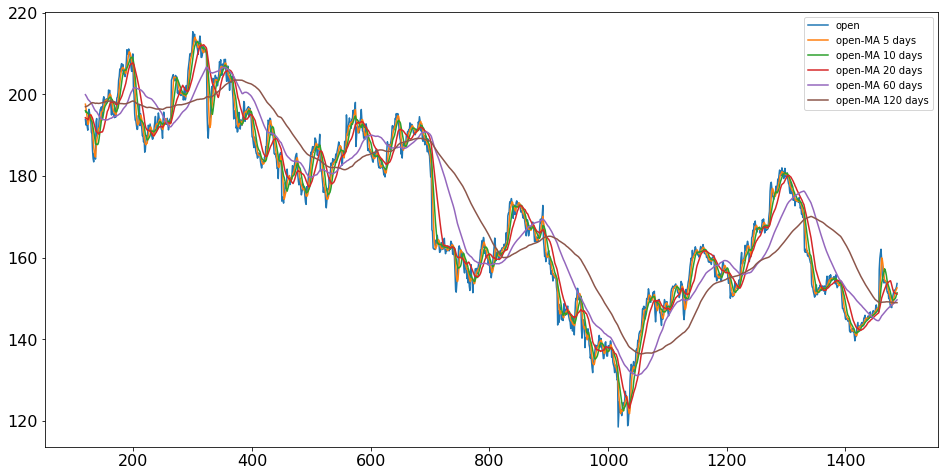

In [52]:
# 開盤價的 MOVING AVERAGE 示意圖 (Plotting Open Price and Simple)
# moving average of 30 days using .plot() method
print("開盤價的 MOVING AVERAGE 示意圖")
ax = raw_train_df[['open', 'open-MA 5 days', 'open-MA 10 days', 'open-MA 20 days', 'open-MA 60 days', 'open-MA 120 days']].plot(
              label='RELIANCE', figsize=(16, 8), fontsize=16, style='-')
ax.figure.savefig(f'./img/MA_OpenPrice.jpg')

收盤價的 MOVING AVERAGE 示意圖


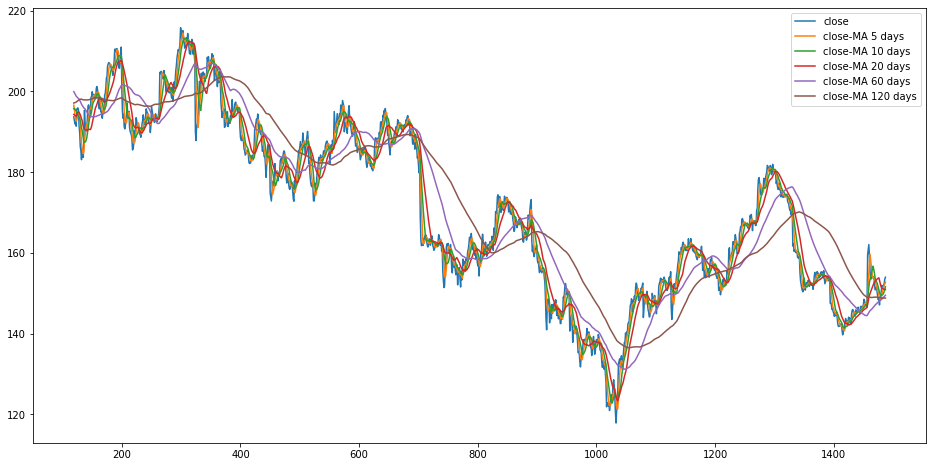

In [53]:
# 收盤價的 MOVING AVERAGE 示意圖 (Plotting Close Price and Simple)
# moving average of 30 days using .plot() method
print("收盤價的 MOVING AVERAGE 示意圖")
ax = raw_train_df[['close', 'close-MA 5 days', 'close-MA 10 days', 'close-MA 20 days', 'close-MA 60 days', 'close-MA 120 days']].plot(
              label='RELIANCE', figsize=(16, 8), style='-')
ax.figure.savefig(f'./img/MA_ClosePrice.jpg')

## Make Dataset

In [54]:
def GenerateDataset(Raw_Data_df:pd.DataFrame, 
                    offset:int, num_features:int, columns_to_be_label:list, predict_num_days:int,
                    Generated_dataset_dict:dict, NewAppendData:pd.core.series.Series,
                    print_explain:bool):
    '''功能 1: 產生新的盛裝 Numpy 資料集 (用 dict 成裝, 訓練集或測試集都可製作)
    功能 2: 當輸入『現有的 numpy 資料集』及『(預測結束後) 當天的原始資料』，就能製作一筆新的 numpy 資料並 append 至現有的 numpy 資料集
    ---
    Paremeters:
    * 功能 1:
      * Raw_Data_df (DataFrame): 原始 pandas df 資料表
      * offset (int): 用於產生 input x, offset 即 lstm 的 steps,表示欲製作的 numpy 資料集，要往前看幾天份的資料 （往前看 offset 天）
      * num_features (int): 用於產生 input x, 特徵數量
      * columns_to_be_label (list of str): 用於產生 label y, 此為原始 pandas df 資料表中要選作為 label 的「欄位名稱」
      * predict_num_days (int): 預測未來幾天
    * 功能 2 (只會於 model inference 之後使用):
      * Generated_dataset_dict (dict of numpy array): 昨天產生的 numpy 資料集
      * NewAppendData (one sample of pd.DataFrame): 今天收盤後的「今日資料」, 用於產生新的 numpy 資料集
    * print_explain (bool): 是否要印出解釋數據？
    ---
    Returns: 
    * NumpyDataset_dict (dict of numpy arrays): 新的 Numpu Dataset
    * 新的 raw data pandas 資料表 (若使用功能 2, 此表會新增一筆資料)
    '''
    # 初始化: Numpy 資料集
    NumpyDataset_dict = {'x':np.empty(shape=(0,offset,num_features)), 'y':np.empty(shape=(0,2*predict_num_days,1))}
    # 逐筆製作 numpy 資料並 append 至 Numpy 資料集
    for date in range(1, len(Raw_Data_df)-offset-predict_num_days+1):
      # 製作一筆 x data: 每 offset 天的 features 製作成一筆 x data
      one_sample_x_np = Raw_Data_df[date:date+offset].to_numpy()
      NumpyDataset_dict['x'] = np.append(NumpyDataset_dict['x'], one_sample_x_np[np.newaxis,:], axis=0)
      # 製作一筆 y data: 將未來的？天的開盤價及收盤價製作成一筆 y data
      # 初始化: y data 
      one_sample_y_np = np.empty(shape=(0, 1))
      for future_date in range(predict_num_days):
        # 依欲預測的未來天數, 逐日取出 label data
        one_sample_y_np = np.append(one_sample_y_np, Raw_Data_df[columns_to_be_label].iloc[date+offset+future_date].to_numpy()[:,np.newaxis], axis=0)
      NumpyDataset_dict['y'] = np.append(NumpyDataset_dict['y'], one_sample_y_np[np.newaxis,:], axis=0)
    
    if print_explain:
      print(f"資料集 x shpae = {NumpyDataset_dict['x'].shape}:\n" \
            f"{NumpyDataset_dict['x'].shape[0]} samples(資料筆數),\n" \
            f"{NumpyDataset_dict['x'].shape[1]} steps({offset}天),\n" \
            f"{NumpyDataset_dict['x'].shape[2]} features(特徵數量)\n")
      print(f"資料集 y shpae = {NumpyDataset_dict['y'].shape}:\n" \
            f"{NumpyDataset_dict['y'].shape[0]} samples(資料筆數),\n" \
            f"{NumpyDataset_dict['y'].shape[1]} labels(特徵數量) 0:明天開盤價, 1:明天收盤價, 依此類推\n" \
            f"{NumpyDataset_dict['y'].shape[2]} (開盤價/收盤價)")

    return NumpyDataset_dict


### Traning Set (dict of numpy arrays)

In [55]:
# [Train_set_1] 往前回推，每 120 天,預測未來 1 天
Train_set_1 = GenerateDataset(raw_train_df,
                      offset=120, num_features=len(raw_train_df.columns), 
                      columns_to_be_label=['open','close'], predict_num_days=1,
                      Generated_dataset_dict=None, NewAppendData=None,
                      print_explain=True)

資料集 x shpae = (1248, 120, 14):
1248 samples(資料筆數),
120 steps(120天),
14 features(特徵數量)

資料集 y shpae = (1248, 2, 1):
1248 samples(資料筆數),
2 labels(特徵數量) 0:明天開盤價, 1:明天收盤價, 依此類推
1 (開盤價/收盤價)


In [56]:
# 檢核 y 值確實是對應 x 隔天的開盤/收盤價
# * 因為 dataset 是每 120 天的資料，預測第 121 天的開盤價、收盤價
#   所以 Train_set_1['x'][0] 並不會包含 Train_set_1['y'][0] 的資料
#   而是 Train_set_1['x'] 的下一筆的第120天的資料 (Train_set_1['x'][1, -1]) 會包含 Train_set_1['y'][0] 的開盤價、收盤價
#   精確來說 Train_set_1['x'][1:,-1,[0,3]] ([0,3] 對應 ['開盤價', '收盤價'] 的編號) 會等於 Train_set_1['y'][:-1].squeeze() (因為原本把資料放到 asix 2)
# * Train_set_1['x'] 沒有任何一筆資料會包含 Train_set_1['y'][-1] 的資料
# * np.array_equal() 會比較兩個 numpy array，維度、內容完全一致才會回傳 True
if np.array_equal(Train_set_1['x'][1:,-1,[0,3]], Train_set_1['y'][:-1].squeeze()):
    print("所有資料都相同，x 與 y 切割正確")
else:
    print("Error: x 與 y 切割錯誤")

所有資料都相同，x 與 y 切割正確


In [57]:
# [Train_set_2] 往前回推，每 120 天,預測未來 1 天
Train_set_2 = GenerateDataset(raw_train_df,
                      offset=120, num_features=len(raw_train_df.columns), 
                      columns_to_be_label=['open','close'], predict_num_days=2,
                      Generated_dataset_dict=None, NewAppendData=None,
                      print_explain=True)

資料集 x shpae = (1247, 120, 14):
1247 samples(資料筆數),
120 steps(120天),
14 features(特徵數量)

資料集 y shpae = (1247, 4, 1):
1247 samples(資料筆數),
4 labels(特徵數量) 0:明天開盤價, 1:明天收盤價, 依此類推
1 (開盤價/收盤價)


In [58]:
# 檢核 y 值確實是對應 x 隔天的開盤/收盤價
if np.array_equal(Train_set_2['x'][1:-1,-1,[0,3]], Train_set_2['y'][:-2,0:2].squeeze())and \
   np.array_equal(Train_set_2['x'][2:,-1,[0,3]], Train_set_2['y'][:-2,2:].squeeze()):
    print("所有資料都相同，x 與 y 切割正確")
else:
    print("Error: x 與 y 切割錯誤")

所有資料都相同，x 與 y 切割正確


## Build Model 

In [59]:
def Build_Model(input_dims, output_dims, num_output_layer, name, model_type, ):
    '''Functional API format: 
    keras functional api is a highly customizable design.
    This is Kuihao's style model builder.'''
    # Define input layer with shape 
    input_layer = tf.keras.Input(shape=input_dims) 

    # Construct NN connections
    x = input_layer # apply to input layer
    
    if model_type == 'LSTM':
        x = tf.keras.layers.LSTM(units=20, activation='relu', return_sequences=True)(x)
        x = tf.keras.layers.LSTM(units=10, activation='relu', return_sequences=False)(x)

    if model_type == 'GRU':
        x = tf.keras.layers.GRU(units=20, activation='relu', return_sequences=True)(x)
        x = tf.keras.layers.GRU(units=10, activation='relu', return_sequences=False)(x)
    
    # Concatenate other NN
    #x = tf.keras.layers.Concatenate()([x])
    
    # apply to outout layer with shape
    if num_output_layer == 1:
        output_layer = tf.keras.layers.Dense(output_dims, activation='relu')(x)
        return tf.keras.Model(inputs=[input_layer], outputs=[output_layer], name=name)
    else:
        output_layer_1 = tf.keras.layers.Dense(output_dims, activation='relu')(x)
        output_layer_2 = tf.keras.layers.Dense(output_dims, activation='relu')(x)
        return tf.keras.Model(inputs=[input_layer], outputs=[output_layer_1, output_layer_2], name=name)

    

### Train Model 1 (預測隔天開盤及收盤)

In [60]:
# Create an instance of the model
model_1 = Build_Model(input_dims=(120,14), output_dims=2, name='Stock_Price_tomorrow', 
                      num_output_layer=1, model_type='GRU')
model_1.summary()

Model: "Stock_Price_tomorrow"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 14)]         0         
_________________________________________________________________
gru_4 (GRU)                  (None, 120, 20)           2160      
_________________________________________________________________
gru_5 (GRU)                  (None, 10)                960       
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
Total params: 3,142
Trainable params: 3,142
Non-trainable params: 0
_________________________________________________________________


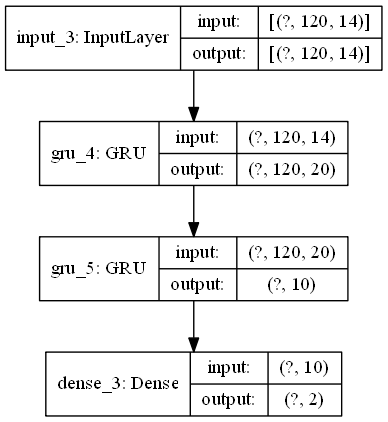

In [61]:
# 印出模型結構圖 Print out model struct digram
tf.keras.utils.plot_model(model_1, to_file=f'{log_dirName}/model1_struct.png', show_shapes=True, show_layer_names=True, dpi=100)

In [62]:
# optimizer
myAdam =  tf.keras.optimizers.Adam(learning_rate=1e-4,)
RMSE_loss = tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error', dtype=None)
model_1.compile(optimizer=myAdam, loss='mse',  metrics=[RMSE_loss])

# Setting early stop
#EarlyStopor = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

In [63]:
# Training
'''
history = model_1.fit(Train_set_1['x'], 
                      Train_set_1['y'], # 注意: python 3.6.4 搭配的 tensorflow  2.1.0, Keras-Applications 1.0.8, 對於多輸入、多輸出的參數格式只支援 numpy，後來的更新版材支援 list 輸入
                      epochs=120,
                      batch_size=32,) # features # tomorrow open price # tomorrow close price # callbacks=[EarlyStopor] 
'''

"\nhistory = model_1.fit(Train_set_1['x'], \n                      Train_set_1['y'], # 注意: python 3.6.4 搭配的 tensorflow  2.1.0, Keras-Applications 1.0.8, 對於多輸入、多輸出的參數格式只支援 numpy，後來的更新版材支援 list 輸入\n                      epochs=120,\n                      batch_size=32,) # features # tomorrow open price # tomorrow close price # callbacks=[EarlyStopor] \n"

In [64]:
# 輸出 loss 曲線
'''
plt.plot(history.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.savefig(f'{log_dirName}/model1_loss.png')
plt.show()
'''

'\nplt.plot(history.history[\'loss\'], label="loss")\nplt.legend(loc="upper right")\nplt.savefig(f\'{log_dirName}/model1_loss.png\')\nplt.show()\n'

In [65]:
# save model
safely_mkdir('./model')
#model_1.save(f'./model/model1_{datetime_thisRun.strftime("%Y_%m_%d__%H_%M_%S")}.h5')

Directory is exist.


'./model'

### Train Model 2 (預測明後兩天開盤及收盤)

In [66]:
# Create an instance of the model
model_2 = Build_Model(input_dims=(120,14), output_dims=2, name='Stock_Price_2_days',
                      num_output_layer=2, model_type='GRU')
model_2.summary()

Model: "Stock_Price_2_days"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 120, 14)]    0                                            
__________________________________________________________________________________________________
gru_6 (GRU)                     (None, 120, 20)      2160        input_4[0][0]                    
__________________________________________________________________________________________________
gru_7 (GRU)                     (None, 10)           960         gru_6[0][0]                      
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 2)            22          gru_7[0][0]                      
_________________________________________________________________________________

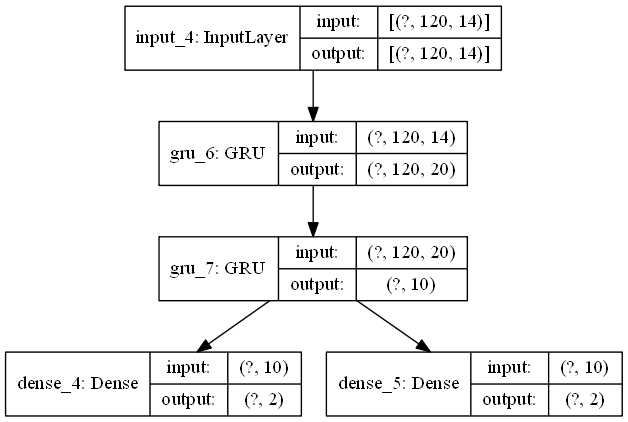

In [67]:
# 印出模型結構圖 Print out model struct digram
tf.keras.utils.plot_model(model_2, to_file=f'{log_dirName}/model2_struct.png', show_shapes=True, show_layer_names=True, dpi=100)

In [68]:
# optimizer
myAdam =  tf.keras.optimizers.Adam(learning_rate=1e-4,)
RMSE_loss = tf.keras.metrics.RootMeanSquaredError(name='root_mean_squared_error', dtype=None)
model_2.compile(optimizer=myAdam, loss='mse',  metrics=[RMSE_loss])

# Setting early stop
#EarlyStopor = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=50)

In [69]:
Train_set_2['y'][:,:2].shape

(1247, 2, 1)

In [70]:
# Training
'''
history2 = model_2.fit(Train_set_2['x'], 
                      [Train_set_2['y'][:,:2], Train_set_2['y'][:,2:]], # 注意: python 3.6.4 搭配的 tensorflow  2.1.0, Keras-Applications 1.0.8, 對於多輸入、多輸出的參數格式只支援 numpy，後來的更新版材支援 list 輸入
                      epochs=150,
                      batch_size=32,) # features # tomorrow open price # tomorrow close price # callbacks=[EarlyStopor] 
'''

"\nhistory2 = model_2.fit(Train_set_2['x'], \n                      [Train_set_2['y'][:,:2], Train_set_2['y'][:,2:]], # 注意: python 3.6.4 搭配的 tensorflow  2.1.0, Keras-Applications 1.0.8, 對於多輸入、多輸出的參數格式只支援 numpy，後來的更新版材支援 list 輸入\n                      epochs=150,\n                      batch_size=32,) # features # tomorrow open price # tomorrow close price # callbacks=[EarlyStopor] \n"

In [71]:
# 輸出 loss 曲線
'''
plt.plot(history2.history['loss'], label="loss")
plt.legend(loc="upper right")
plt.savefig(f'{log_dirName}/model2_loss.png')
plt.show()
'''

'\nplt.plot(history2.history[\'loss\'], label="loss")\nplt.legend(loc="upper right")\nplt.savefig(f\'{log_dirName}/model2_loss.png\')\nplt.show()\n'

In [72]:
# save model
safely_mkdir('./model')
#model_2.save(f'./model/model2_{datetime_thisRun.strftime("%Y_%m_%d__%H_%M_%S")}.h5')

Directory is exist.


'./model'

In [73]:
'''
predict = model_2.predict(Train_set_2['x'])
plt.plot(Train_set_2['y'][:,0], color='black') # 黑線是 Train set y 值，即隔天實際開盤價，共 1248 天
plt.plot(predict[0], color='orange') # 橘線是 model prediction，即模型預測的隔日開盤價，共 1248 天
plt.plot(predict[1], color='red') # 紅線是 model prediction，即模型預測的後天開盤價，共 1248 天
plt.show()
'''

"\npredict = model_2.predict(Train_set_2['x'])\nplt.plot(Train_set_2['y'][:,0], color='black') # 黑線是 Train set y 值，即隔天實際開盤價，共 1248 天\nplt.plot(predict[0], color='orange') # 橘線是 model prediction，即模型預測的隔日開盤價，共 1248 天\nplt.plot(predict[1], color='red') # 紅線是 model prediction，即模型預測的後天開盤價，共 1248 天\nplt.show()\n"

### Simple prediction (use training data)
#### 模擬 testing data 的操作方式
使用訓練資料的最後倒數的 120 筆資料，進行模型預測 (預測明日開盤、收盤價)

In [74]:
# load pre-train model
#model_1_load = tf.keras.models.load_model(f'./model/model1_{datetime_thisRun.strftime("%Y_%m_%d__%H_%M_%S")}.h5')
model_1_load = tf.keras.models.load_model(f'./model/model1_2022_04_21__21_08_52.h5')
# model predict 
model_1_load.predict(Train_set_1['x'][-1:])

array([[152.65175, 150.98741]], dtype=float32)

In [75]:
# load pre-train model
#model_2_load = tf.keras.models.load_model(f'./model/model2_{datetime_thisRun.strftime("%Y_%m_%d__%H_%M_%S")}.h5')
model_2_load = tf.keras.models.load_model(f'./model/model2_2022_04_21__21_08_52.h5') # 這有 Train 起來，預測兩天的模型有機率 Train 壞
# model predict 
model_2_load.predict(Train_set_2['x'][-1:])

[array([[150.83104, 151.46785]], dtype=float32),
 array([[151.55235, 151.86894]], dtype=float32)]

#### 檢視訓練資料的預測狀況
對所有訓練資料進行預測，繪製 預測值 與 Ground truth 的趨勢曲線，檢視目前模型的訓練狀況


「模型預測」與「真實數值」的「開盤價」曲線圖:


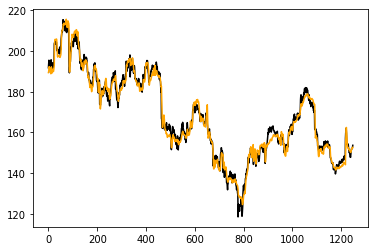

In [76]:
predicts = model_1_load.predict(Train_set_1['x'])

print("\n「模型預測」與「真實數值」的「開盤價」曲線圖:")
plt.plot(Train_set_1['y'][:,0], color='black') # 黑線是 Train set y 值，即隔天實際開盤價，共 1248 天
plt.plot(predicts[:,0:1], color='orange') # 橘線是 model prediction，即模型預測的開盤價，共 1248 天
plt.savefig(f'{log_dirName}/model1_predict_vs_truth.png')
plt.show()


「模型預測」與「真實數值」的「開盤價」曲線圖:


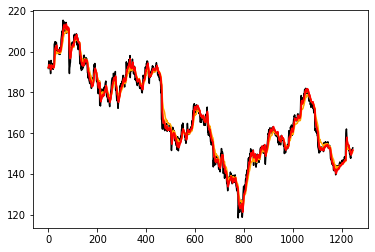

In [77]:
predicts2 = model_2_load.predict(Train_set_2['x'])

print("\n「模型預測」與「真實數值」的「開盤價」曲線圖:")
plt.plot(Train_set_2['y'][:,0], color='black') # 黑線是 Train set y 值，即隔天實際開盤價，共 1248 天
plt.plot(predicts2[0], color='orange') # 橘線是 model prediction，即模型預測的隔日開盤價，共 1248 天
plt.plot(predicts2[1], color='red') # 紅線是 model prediction，即模型預測的後天開盤價，共 1248 天
plt.savefig(f'{log_dirName}/model2_predict_vs_truth.png')
plt.show()

## Stock Strategy
買賣決策
* 提供參考: [KD指標-KD黃金交叉建議做多-死亡交叉建議做空](https://ithelp.ithome.com.tw/articles/10206894)
Inference 注意事項
* 依規定必須「輸出明日模型預測」和「讀取一天資料」**輪流進行**
* output.csv 不可以預先讀入，必須完全由 code 執行時產生並輸出

## Trader class
依範例程式，可以寫一個名為 Trader 的 class 方便助教檢驗程式<br>
此類別會實作下列方法 (method):
* train(load_data:pd.DataFrame, hyperparameter:list, usePreTrain:bool): 匯入訓練資料並執行 model 訓練
    * 新增參數: 
        * hyperparameter: lr, optimizer, random seed...etc
        * usePreTrain: 是否使用預訓練模型
    * load data preprocess
    * build model
    * load model
    * model training
    * model save
* predict_action(row): 依讀入的單行資料進行 model inference
    * 讀入當天資料之後，才進行模型預測、決策邏輯，再輸出明天的操盤行為 (action)
    * 需要將本日讀入的資料放進訓練集之中
* re_training(doReTrain:bool): 使用本日資料重新 Training
    * 新增參數:
        * doReTrain: 是否執行重新訓練

In [79]:
class Trader():
    def __init__(self):
        
        pass

    def train(self, load_data:pd.DataFrame=None, 
              hyperparameter:list=None, usePreTrain:bool=True):
        '''時間因素，只實作使用預訓練模型、不給調整 hyperparameter'''
        pass      

    def predict_action(self, row):
        pass

    def re_training(self, doReTrain:bool):
        pass


## Main
Notice: 
* 每讀完一天的資料，就必須輸出隔天是否要購買股票，輸出後才能再讀下一天的資料，以此類推。
    * E.g.:
        * D = 新的一天股票資料產生
        * A = 模型執行的動作 (-1, 0, 1)
        * 合法的順序： DADADADADA
* 違反下列規則 0 分計算:
    * 使用非法的測試資料讀取方式，E.g.: DDDDDADDA
    * 一次讀完全部股票資料才輸出是否要購買
    * 修改輸出結果
    * 輸出結果數量不正確
    * Your code is the same as other classmate’s.
    * Your Github repo does not contain your code.
    * You do not submit the homework before the deadline.
    * **The training dataset you used is not provided by TA. (言下之意，不能更改/新增 training data)** 
    * Your code can get data through the Internet during training or testing. (不能使用爬蟲) 
    * Your code terminates during testing.



In [80]:
"""
# Functions
def load_data(load_file_dir:str):
    return pd.read_csv(load_file_dir, header=None)

# You can write code above the if-main block.

if __name__ == "__main__":
    # You should not modify this part.
    import argparse

    parser = argparse.ArgumentParser()
    parser.add_argument("--training", default="training_data.csv", help="input training data file name")
    parser.add_argument("--testing", default="testing_data.csv", help="input testing data file name")
    parser.add_argument("--output", default="output.csv", help="output file name")
    args = parser.parse_args()

    # The following part is an example.
    # You can modify it at will.
    training_data = load_data(args.training)
    trader = Trader()
    trader.train(training_data)

    testing_data = load_data(args.testing)
    with open(args.output, "w") as output_file:
        for row in testing_data:
            # We will perform your action as the open price in the next day.
            action = trader.predict_action(row)
            output_file.write(action)

            # this is your option, you can leave it empty.
            trader.re_training()
"""
print("mute")


mute
